# French Level Detector


## 1. Project Introduction

To improve one's foreign language level, reading text suit for the reader's level is an efficient way. This project built a model for English speakers that predicts the difficulty of a French written text. Six levels will be detected: A1, A2, B1, B2, C1, C2. This can be used in a recommendation system to recommend texts for readers.

## 2. Text Preparation

### 2.1 Install useful liabraries

First, we need to install the libraries with their French-language model.

In [ ]:
# Install and update spaCy
!pip install -U spacy

# Download the french language model
!python -m spacy download fr


In [40]:
# Import required packages
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
sns.set_style("whitegrid")

# Import additional packages
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from spacy.lang.fr.stop_words import STOP_WORDS
from spacy.lang.fr import French
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn. preprocessing import StandardScaler


### 2.2 Load Training Data

In [41]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [42]:
# Load Training data
url = "https://raw.githubusercontent.com/JW20221/DMML2022_Ouchy/main/Data/training_data.csv"
df = pd.read_csv(url)
df.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


Add one additional feature: total words. Usually, the more words in a sentence, the higher French level. We will see if this feature can help with our proection. 

In [55]:
# add a column of totwl words in a sentence
df['totalwords'] = df['sentence'].str.count(' ') +1
df = df[['sentence', 'totalwords', 'difficulty']]
df.head()


,sentence,totalwords,difficulty
0,Les coûts kilométriques réels peuvent diverger...,38,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",12,A1
2,Le test de niveau en français est sur le site ...,13,A1
3,Est-ce que ton mari est aussi de Boston?,8,A1
4,"Dans les écoles de commerce, dans les couloirs...",34,B1


Check the data information.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence    4800 non-null   object
 1   totalwords  4800 non-null   int64 
 2   difficulty  4800 non-null   object
dtypes: int64(1), object(2)
memory usage: 112.6+ KB


Check the data if it is balanced.

In [45]:
# Base rate: check is data is balanced.
df.difficulty.value_counts()

A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: difficulty, dtype: int64

We can tell it is a balanced data.

### 2.3 Tokenization and Data cleaning

**Tokenization** is the process of breaking a text into pieces called tokens. A token simply refers to an individual part of a sentence having some semantic value. SpaCy‘s tokenizer takes input in form of unicode text and outputs a sequence of token objects. In addition, SpaCy automatically breaks your document into tokens when a document is created using the language model.

During this step, we also process **Data cleaning**. However, to compare the results before and after data cleaning. First, we disabled the function of **Remove stop words and ponctuations** to get the results without data cleaning, then we enable the function later to get the results with data cleaning.

In [56]:
# Create a list of punctuation marks
punctuations = string.punctuation

punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [57]:
# Create a list of stopwords
stop_words = spacy.lang.fr.stop_words.STOP_WORDS

list(stop_words)[:10]

['mille',
 'lors',
 'enfin',
 'memes',
 'ait',
 'vingt',
 'elle-même',
 'dessus',
 'je',
 'étant']

In [58]:
## Load French language model
sp = spacy.load('fr_core_news_sm')

# Create tokenizer function
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Return preprocessed list of tokens
    return mytokens


Try the tokenizer function with a sentence.

In [59]:
df.iloc[1, 0]

"Le bleu, c'est ma couleur préférée mais je n'aime pas le vert!"

In [60]:
spacy_tokenizer(df.iloc[1,0])

['bleu', 'couleur', 'préférer', 'aime', 'vert']

## 3. Text Representation
At this point, we need to represent the text numericaly. There are different ways to do it. Bag of Words (BOW), TP-IDF Representation, and Word2Vec are commonly used. I tried all three, TP-IDF gave better results than BOW, but I couldn't implement Word2Vec correctly. So, here I demonstrate with TF-IDF Representation.

### 3.1 TF-IDF Representation


Recall that:

- **term frequency tf** = count(word, document) / len(document) 
- **term frequency idf** = log( len(collection) / count(document_containing_term, collection) )
- **tf-idf** = tf * idf 

  (The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.) [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer)

It is important to mention that the IDF value for a word remains the same throughout all the documents as it depends upon the total number of documents. On the other hand, TF values of a word differ from document to document.

In [61]:
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer) # we use the above defined tokenizer

## 4. Text Classification

### 4.1 Logistic regression

In [62]:
# Select features
X = df['sentence'] # the features we want to analyze
ylabels = df['difficulty'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=0, stratify=ylabels)


In [63]:
# Define classifier
classifier_1 = LogisticRegression()

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
pipe_1 = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier_1)])

# Fit model on training set
pipe_1.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f96d102a5e0>)),
                ('classifier', LogisticRegression())])

In [64]:
# Predictions
y_pred = pipe_1.predict(X_test)

In [65]:
# Evaluate the model
def evaluate(true, pred):
    precision = precision_score(true, pred, average='weighted')
    recall = recall_score(true, pred, average='weighted')
    f1 = f1_score(true, pred, average='weighted')
    print(f"CONFUSION MATRIX:\n")
    conf_mat = confusion_matrix(true, pred)
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

CONFUSION MATRIX:



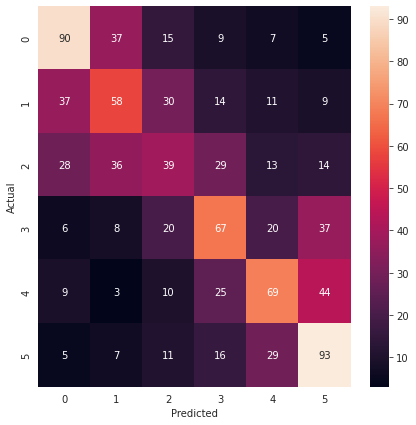

ACCURACY SCORE:
0.4333
CLASSIFICATION REPORT:
	Precision: 0.4268
	Recall: 0.4333
	F1_Score: 0.4280


In [66]:
# Evaluation - test set
evaluate(y_test, y_pred)

### 4.2 KNN

Define the vectorizer and the classification method.

In [67]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

pipe_2 = Pipeline([('vectorizer',tfidf_vector),
                 ('classifier',knn)])
pipe_2.fit(X_train, y_train)

y_pred = pipe_2.predict(X_test)


Evaluate

CONFUSION MATRIX:



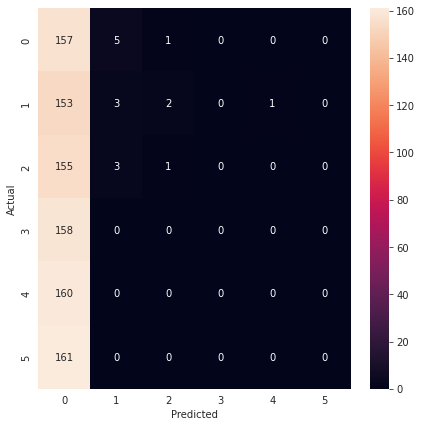

ACCURACY SCORE:
0.1677
CLASSIFICATION REPORT:
	Precision: 0.1148
	Recall: 0.1677
	F1_Score: 0.0560


In [68]:
evaluate(y_test,y_pred)

### 4.3 Decision Tree

In [69]:
# Define classifier
dtc = DecisionTreeClassifier(random_state=0)

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
pipe_3 = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', dtc)])

# Fit model on training set
pipe_3.fit(X_train, y_train)

y_pred_3 = pipe_3.predict(X_test)

Evaluate

CONFUSION MATRIX:



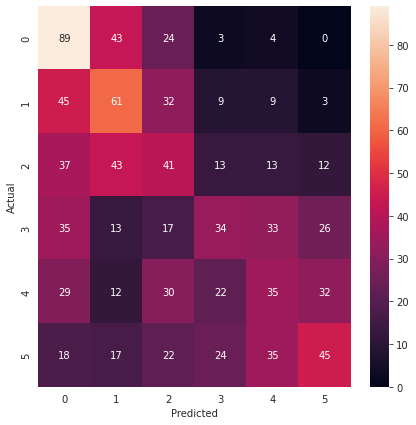

ACCURACY SCORE:
0.3177
CLASSIFICATION REPORT:
	Precision: 0.3166
	Recall: 0.3177
	F1_Score: 0.3095


In [70]:
evaluate(y_test,y_pred_3)

### 4.4 Random Forest

In [71]:
# Use random forest
from sklearn.ensemble import RandomForestClassifier

# Define vectorizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer) # we use the above defined tokenizer

# Define classifier
classifier_4 = RandomForestClassifier(n_estimators=50)

# Create pipeline
pipe_4 = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier_4)])

# Generate Model on training set
pipe_4.fit(X_train, y_train)

# Predictions
y_pred_4 = pipe_4.predict(X_test)


Evaluate

CONFUSION MATRIX:



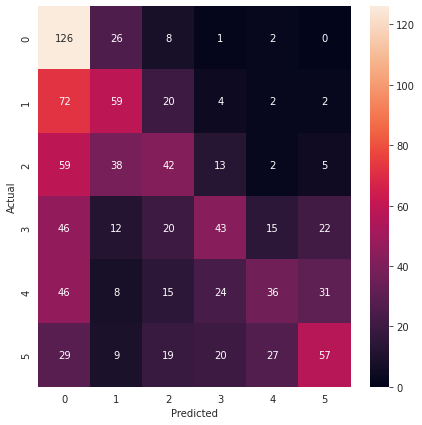

ACCURACY SCORE:
0.3781
CLASSIFICATION REPORT:
	Precision: 0.3975
	Recall: 0.3781
	F1_Score: 0.3629


In [72]:
evaluate(y_test,y_pred_4)

### 4.5 Linear SVC with Doc2Vec

In [32]:
from gensim.models.doc2vec import TaggedDocument

import multiprocessing
cores = multiprocessing.cpu_count()

# Set difficulty tags
texts_tagged = df.apply(
    lambda r: TaggedDocument(words=spacy_tokenizer(r.sentence), tags=[r.difficulty]), axis=1)

In [33]:
#Build the the vocabulary
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=0, vector_size=35, negative=6, hs=0, min_count=1, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in texts_tagged.values])

In [34]:
# Train distributed Bag of Word model
model_dbow.train(texts_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [35]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [36]:
train_tagged, test_tagged = train_test_split(texts_tagged, test_size=0.2, random_state=1234)

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
     

CONFUSION MATRIX:



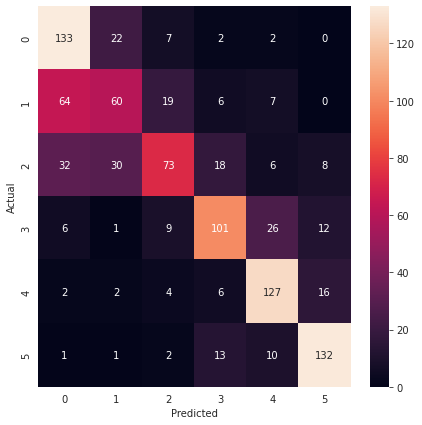

ACCURACY SCORE:
0.6521
CLASSIFICATION REPORT:
	Precision: 0.6506
	Recall: 0.6521
	F1_Score: 0.6420


In [37]:
from sklearn.svm import LinearSVC

#Train the model
lsvc = LinearSVC(verbose=0)

# Fit model on training set
lsvc.fit(X_train, y_train)
# Predictions
y_pred = lsvc.predict(X_test)

# Evaluation - test set
evaluate(y_test, y_pred)

## 5. Retrain the best model with full data

After comparing the four models: Logistic Regression, KNN, Decision Tree, and Random Forest, we know the Logistic Regression is the best one for our data.

In [ ]:
X

0       Les coûts kilométriques réels peuvent diverger...
1       Le bleu, c'est ma couleur préférée mais je n'a...
2       Le test de niveau en français est sur le site ...
3                Est-ce que ton mari est aussi de Boston?
4       Dans les écoles de commerce, dans les couloirs...
                              ...                        
4795    C'est pourquoi, il décida de remplacer les hab...
4796    Il avait une de ces pâleurs splendides qui don...
4797    Et le premier samedi de chaque mois, venez ren...
4798    Les coûts liés à la journalisation n'étant pas...
4799    Sur le sable, la mer haletait de toute la resp...
Name: sentence, Length: 4800, dtype: object

In [ ]:
pipe_1.fit(X, ylabels)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f341724fb80>)),
                ('classifier', LogisticRegression())])

In [ ]:
y_pred = pipe_1.predict(X_test)

evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[132  18   6   5   1   1]
 [ 10 126  10   5   4   4]
 [ 13  12 120   9   4   1]
 [  2   3   2 145   3   3]
 [  1   0   0   0 155   4]
 [  0   0   1   0   2 158]]
ACCURACY SCORE:
0.8708
CLASSIFICATION REPORT:
	Precision: 0.8694
	Recall: 0.8708
	F1_Score: 0.8692


## Unlabelled Text Data prediction

In [ ]:
# Load Unlabelled Test Data
url_test = "https://raw.githubusercontent.com/JW20221/DMML2022_Ouchy/main/Data/unlabelled_test_data.csv"
df_unlabelled_test = pd.read_csv(url_test)
df_unlabelled_test.head(10)

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."
5,5,"Elle jeta un cri, un petit cri, voulut se dres..."
6,6,"Madame, Monsieur, Votre fils Léo arrive tous l..."
7,7,Comment tu as trouvé le repas de ce midi
8,8,Mais la racine du mal est bel est bien cette f...
9,9,"Je ne peux pas vous laisser dire cela, Madame."


In [ ]:
# Select features
X_unlabelled_test = df_unlabelled_test['sentence'] # the features we want to analyze

In [ ]:
# Predictions for unlabelled test data
y_pred_unlabelled_test = pipe_1.predict(X_unlabelled_test)
y_pred_unlabelled_test

array(['C1', 'B1', 'A1', ..., 'C2', 'B2', 'C2'], dtype=object)

In [ ]:
# Add column "difficulty"
df_unlabelled_test['difficulty'] = y_pred_unlabelled_test

df_unlabelled_test

,id,sentence,difficulty
0,0,Nous dûmes nous excuser des propos que nous eû...,C1
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...,B1
2,2,"Et, paradoxalement, boire froid n'est pas la b...",A1
3,3,"Ce n'est pas étonnant, car c'est une saison my...",C1
4,4,"Le corps de Golo lui-même, d'une essence aussi...",C2
...,...,...,...
1195,1195,C'est un phénomène qui trouve une accélération...,B1
1196,1196,Je vais parler au serveur et voir si on peut d...,A2
1197,1197,Il n'était pas comme tant de gens qui par pare...,C2
1198,1198,Ils deviennent dangereux pour notre économie.,B2


In [ ]:
df_unlabelled_test.to_csv('Labelled test data with s.csv', index=False)

In [ ]:
#Drop column "sentence"
df_labelled_test = df_unlabelled_test.drop(columns = ['sentence'])
df_labelled_test


,id,difficulty
0,0,C1
1,1,B1
2,2,A1
3,3,C1
4,4,C2
...,...,...
1195,1195,B1
1196,1196,A2
1197,1197,C2
1198,1198,B2


In [ ]:
# Write DataFrame to an CSV file
df_labelled_test.to_csv('Labelled test data.csv', index=False)